## Diffusion demo

En este cuaderno se presenta una demostración práctica del uso de los distintos modelos de difusión desarrollados en el proyecto.

### Librerias ###

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

from functools import partial

import torch
from torch.utils.data import (
    DataLoader,
    Subset,
)
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.transforms import functional

from noise_schedules import LinearSchedule, CosineSchedule
from torchvision import transforms
from utils.data_loader import load_dataset

from utils import (
    plot_image_grid,
    load_dataset,
    plot_image_evolution_color,
    sample_initial_latents,
)

from samplers import predictor_corrector_integrator
from diffusion import VPProcess, VEProcess, SubVPProcess


n_threads = torch.get_num_threads()
print('Number of threads: {:d}'.format(n_threads))

device ='cuda'

Number of threads: 12


### Carga de datos

In [2]:
def colorize_grayscale(tensor_img):
    if tensor_img.shape[0] == 1:
        r, g, b = [torch.rand(1).item() for _ in range(3)]
        return torch.cat([tensor_img * r, tensor_img * g, tensor_img * b], dim=0)
    return tensor_img

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(colorize_grayscale),
])

data= load_dataset("mnist", transform=transform, return_loader=False)

In [3]:
# Create a subset dataset composed of only images of one of the digits
digit = 3
indices_digit = torch.where(data.targets == digit)[0]

data_train = Subset(data, indices_digit)

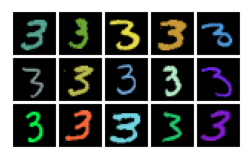

In [4]:
# Visualize training images
n_rows = 3
n_cols = 5

_ = plot_image_grid(
    images=[data_train[i][0] for i in range(n_rows * n_cols)],
    figsize =(3, 3),
    n_rows=n_rows,
    n_cols=n_cols,
)

## Variance Exploiding

In [5]:
sigma = 25.0
diffusion_process = VEProcess(
    sigma=sigma
)

In [ ]:
from score_models import ScoreNet
from torch.optim import Adam
from tqdm.notebook import trange

score_model = torch.nn.DataParallel(
    ScoreNet(marginal_prob_std=diffusion_process.sigma_t, in_channels=3)

)
score_model = score_model.to(device)

batch_size = 32

data_loader = DataLoader(
    data_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_threads,
)

learning_rate = 1.0e-3
optimizer = Adam(score_model.parameters(), lr=learning_rate)

n_epochs =  30
tqdm_epoch = trange(n_epochs)

for epoch in tqdm_epoch:
    avg_loss = 0.0
    num_items = 0
    for x, y in data_loader:
        x = x.to(device)
        y = y.to(device)
        loss = diffusion_process.loss_function(score_model, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]

    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))

    torch.save(score_model.state_dict(), 'check_point.pth')

  0%|          | 0/30 [00:00<?, ?it/s]

In [13]:
n_images = 5

diffusion_coefficient = diffusion_process.diffusion_coefficient

T = 1.0 - 1e-3
T_tensor = torch.tensor([T], device=device)
variance = diffusion_process.sigma_t(T_tensor) ** 2

image_T = sample_initial_latents(
    n_images=n_images,
    image_shape=(3, 28, 28),
    mean=0.0,
    std=1,
    device=torch.device("cuda")
)

with torch.no_grad():
    times, synthetic_images_t = predictor_corrector_integrator(
        image_T,
        t_0=T,
        t_end= 1e-3,
        n_steps= 2000,
        drift_coefficient=lambda x_t, t: diffusion_process.reverse_drift(x_t, t, score_model),
        diffusion_coefficient=diffusion_coefficient,
        score_function=score_model,
        n_corrector_steps=3,
        corrector_step_size=0.0001
   )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.2535295..3.4949782].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.331833..3.5384185].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.7278535..3.4330013].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.0993514..3.3350897].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.6447165..3.28385].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.6793373..3.2752388].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.8097136..

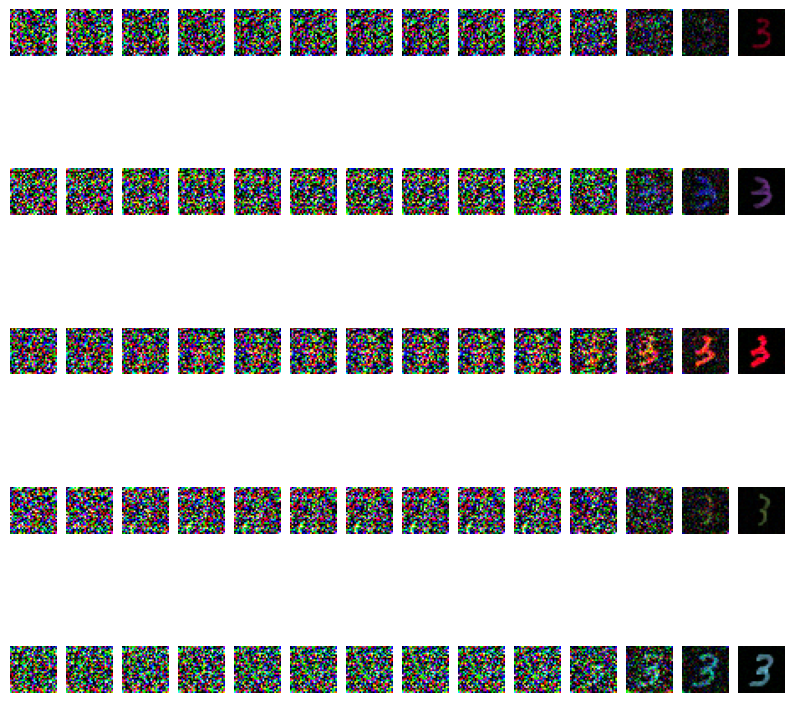

In [14]:
_ = plot_image_evolution_color(
    images=synthetic_images_t.cpu(),
    n_images=n_images,
    n_intermediate_steps=[0, 5, 200, 300, 400, 450, 470, 480, 490, 500, 1000,1500, 1800, 2000],
    figsize=(10, 10),
)

## Variance Preserve with linear noise

In [ ]:
schedule = LinearSchedule(beta_min=0.01, beta_max=5.0)
diffusion_process= VPProcess(noise_schedule=schedule)

In [ ]:
score_model = torch.nn.DataParallel(
    ScoreNet(marginal_prob_std=diffusion_process.sigma_t, in_channels=3)

)
score_model = score_model.to(device)

batch_size = 32

data_loader = DataLoader(
    data_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_threads,
)

learning_rate = 1.0e-3
optimizer = Adam(score_model.parameters(), lr=learning_rate)

n_epochs =  30
tqdm_epoch = trange(n_epochs)

for epoch in tqdm_epoch:
    avg_loss = 0.0
    num_items = 0
    for x, y in data_loader:
        x = x.to(device)
        y = y.to(device)
        loss = diffusion_process.loss_function(score_model, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]

    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))


  0%|          | 0/30 [00:00<?, ?it/s]

In [17]:
n_images = 5

diffusion_coefficient = diffusion_process.diffusion_coefficient

T = 1.0 - 1e-3
T_tensor = torch.tensor([T], device=device)
variance = diffusion_process.sigma_t(T_tensor) ** 2

image_T = sample_initial_latents(
    n_images=n_images,
    image_shape=(3, 28, 28),
    mean=0.0,
    std=variance,
    device=torch.device("cuda")
)

with torch.no_grad():
    times, synthetic_images_t = predictor_corrector_integrator(
        image_T,
        t_0=T,
        t_end= 1e-3,
        n_steps= 2000,
        drift_coefficient=lambda x_t, t: diffusion_process.reverse_drift(x_t, t, score_model),
        diffusion_coefficient=diffusion_coefficient,
        score_function=score_model,
        n_corrector_steps=5,
        corrector_step_size=0.0001
   )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.468371..3.5134614].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.3321369..3.705191].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9920282..3.705743].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.5246778..3.7109394].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9471164..3.5667722].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9625206..3.256092].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.7470627..3

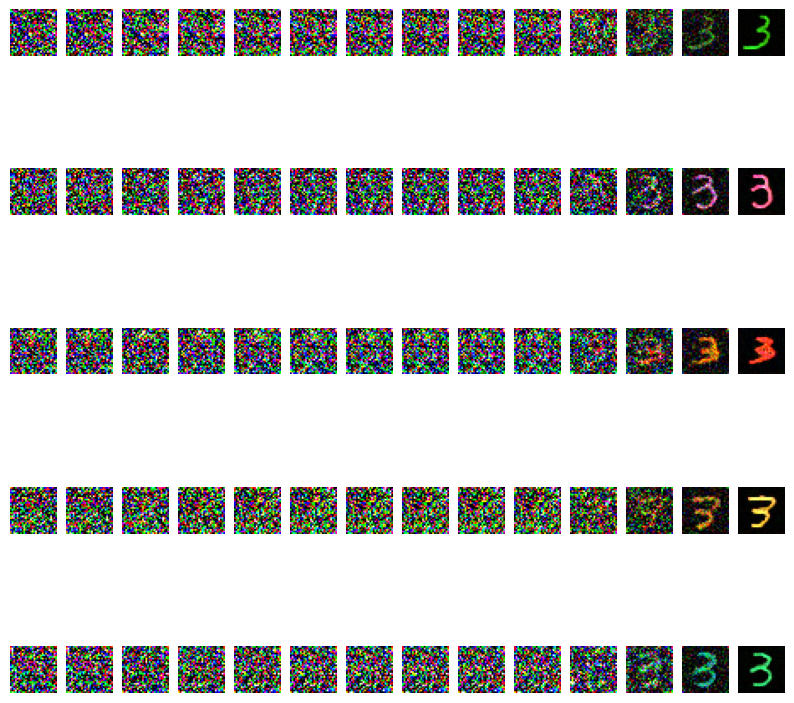

In [18]:
_ = plot_image_evolution_color(
    images=synthetic_images_t.cpu(),
    n_images=n_images,
    n_intermediate_steps=[0, 5, 200, 300, 400, 450, 470, 480, 490, 500, 1000,1500, 1800, 2000],
    figsize=(10, 10),
)

## Variance Preserve with cosine noise

In [ ]:
schedule = CosineSchedule(s=0.008)
diffusion_process= VPProcess(noise_schedule=schedule)

In [ ]:
score_model = torch.nn.DataParallel(
    ScoreNet(marginal_prob_std=diffusion_process.sigma_t, in_channels=3)

)
score_model = score_model.to(device)

batch_size = 32

data_loader = DataLoader(
    data_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_threads,
)

learning_rate = 1.0e-3
optimizer = Adam(score_model.parameters(), lr=learning_rate)

n_epochs =  30
tqdm_epoch = trange(n_epochs)

for epoch in tqdm_epoch:
    avg_loss = 0.0
    num_items = 0
    for x, y in data_loader:
        x = x.to(device)
        y = y.to(device)
        loss = diffusion_process.loss_function(score_model, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]

    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))


  0%|          | 0/30 [00:00<?, ?it/s]

In [21]:
n_images = 5

diffusion_coefficient = diffusion_process.diffusion_coefficient

T = 1.0 - 1e-3
T_tensor = torch.tensor([T], device=device)
variance = diffusion_process.sigma_t(T_tensor) ** 2

image_T = sample_initial_latents(
    n_images=n_images,
    image_shape=(3, 28, 28),
    mean=0.0,
    std=variance,
    device=torch.device("cuda")
)

with torch.no_grad():
    times, synthetic_images_t = predictor_corrector_integrator(
        image_T,
        t_0=T,
        t_end= 1e-3,
        n_steps= 2000,
        drift_coefficient=lambda x_t, t: diffusion_process.reverse_drift(x_t, t, score_model),
        diffusion_coefficient=diffusion_coefficient,
        score_function=score_model,
        n_corrector_steps=5,
        corrector_step_size=0.0001
   )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.7051766..3.8131251].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.6946373..3.8285089].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.7326643..3.209469].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.4964426..3.5604017].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.2246106..3.643624].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.0598388..3.433158].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.1563525..

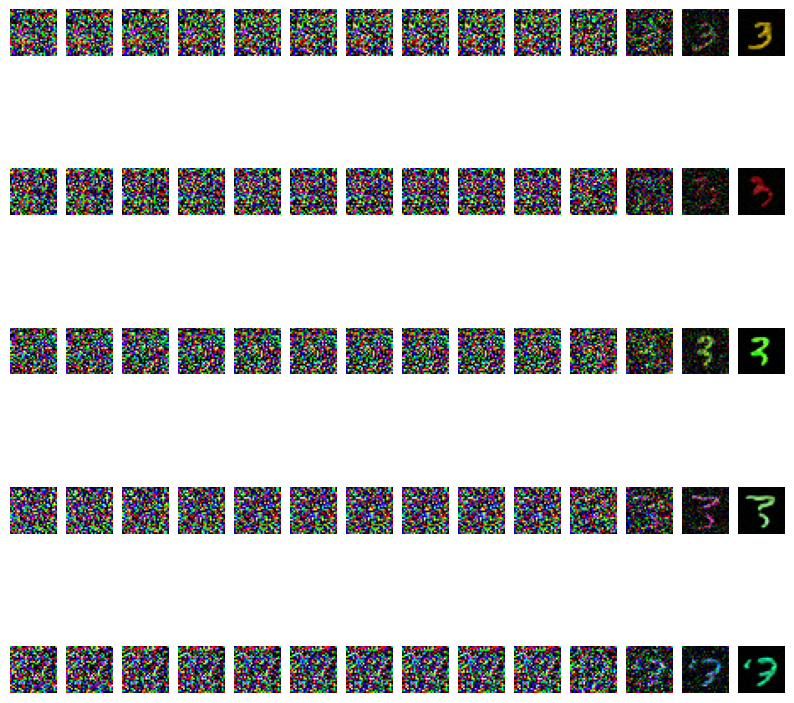

In [22]:
_ = plot_image_evolution_color(
    images=synthetic_images_t.cpu(),
    n_images=n_images,
    n_intermediate_steps=[0, 5, 200, 300, 400, 450, 470, 480, 490, 500, 1000,1500, 1800, 2000],
    figsize=(10, 10),
)

## SubVariance Preserve with cosine noise

In [ ]:
schedule = CosineSchedule(s=0.008)
diffusion_process= SubVPProcess(noise_schedule=schedule)

In [ ]:
score_model = torch.nn.DataParallel(
    ScoreNet(marginal_prob_std=diffusion_process.sigma_t, in_channels=3)

)
score_model = score_model.to(device)

batch_size = 32

data_loader = DataLoader(
    data_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_threads,
)

learning_rate = 1.0e-3
optimizer = Adam(score_model.parameters(), lr=learning_rate)

n_epochs =  30
tqdm_epoch = trange(n_epochs)

for epoch in tqdm_epoch:
    avg_loss = 0.0
    num_items = 0
    for x, y in data_loader:
        x = x.to(device)
        y = y.to(device)
        loss = diffusion_process.loss_function(score_model, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]

    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))


  0%|          | 0/30 [00:00<?, ?it/s]

In [25]:
n_images = 5

diffusion_coefficient = diffusion_process.diffusion_coefficient

T = 1.0 - 1e-3
T_tensor = torch.tensor([T], device=device)
variance = diffusion_process.sigma_t(T_tensor) ** 2

image_T = sample_initial_latents(
    n_images=n_images,
    image_shape=(3, 28, 28),
    mean=0.0,
    std=variance,
    device=torch.device("cuda")
)

with torch.no_grad():
    times, synthetic_images_t = predictor_corrector_integrator(
        image_T,
        t_0=T,
        t_end= 1e-3,
        n_steps= 2000,
        drift_coefficient=lambda x_t, t: diffusion_process.reverse_drift(x_t, t, score_model),
        diffusion_coefficient=diffusion_coefficient,
        score_function=score_model,
        n_corrector_steps=5,
        corrector_step_size=0.0001
   )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.6520371..2.1744053].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.6104472..2.1036744].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.7860992..2.3487396].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4449217..2.3507724].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.8045747..2.6161401].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.7290623..2.4671292].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.716998

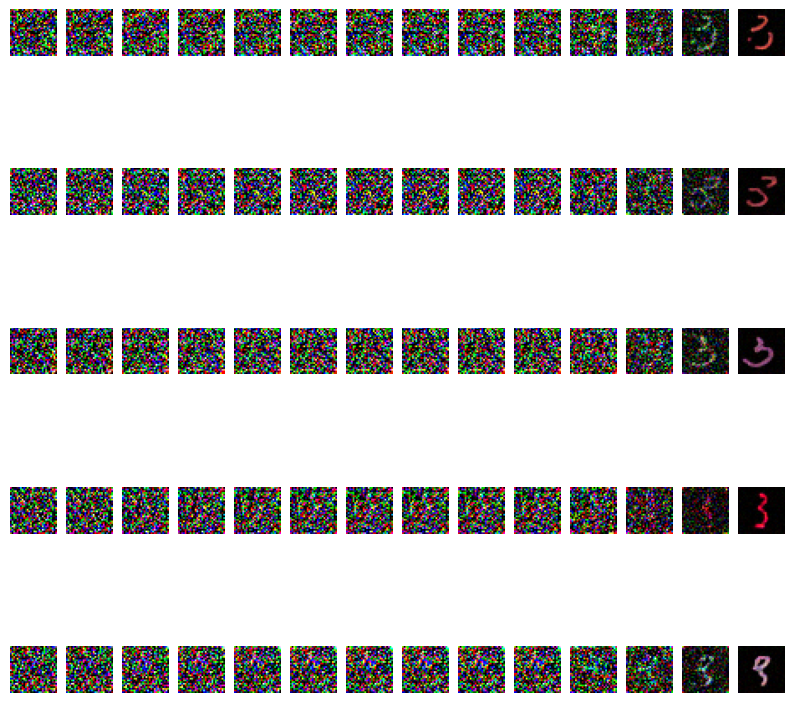

In [26]:
_ = plot_image_evolution_color(
    images=synthetic_images_t.cpu(),
    n_images=n_images,
    n_intermediate_steps=[0, 5, 200, 300, 400, 450, 470, 480, 490, 500, 1000,1500, 1800, 2000],
    figsize=(10, 10),
)

## SubVariance Preserve with linear noise

In [ ]:
schedule = LinearSchedule(beta_min=0.01, beta_max=5.0)
diffusion_process= SubVPProcess(noise_schedule=schedule)

In [ ]:
score_model = torch.nn.DataParallel(
    ScoreNet(marginal_prob_std=diffusion_process.sigma_t, in_channels=3)

)
score_model = score_model.to(device)

batch_size = 32

data_loader = DataLoader(
    data_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_threads,
)

learning_rate = 1.0e-3
optimizer = Adam(score_model.parameters(), lr=learning_rate)

n_epochs =  30
tqdm_epoch = trange(n_epochs)

for epoch in tqdm_epoch:
    avg_loss = 0.0
    num_items = 0
    for x, y in data_loader:
        x = x.to(device)
        y = y.to(device)
        loss = diffusion_process.loss_function(score_model, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]

    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))


  0%|          | 0/30 [00:00<?, ?it/s]

In [33]:
n_images = 5

diffusion_coefficient = diffusion_process.diffusion_coefficient

T = 1.0 - 1e-3
T_tensor = torch.tensor([T], device=device)
variance = diffusion_process.sigma_t(T_tensor) ** 2

image_T = sample_initial_latents(
    n_images=n_images,
    image_shape=(3, 28, 28),
    mean=0.0,
    std=variance,
    device=torch.device("cuda")
)

with torch.no_grad():
    times, synthetic_images_t = predictor_corrector_integrator(
        image_T,
        t_0=T,
        t_end= 1e-3,
        n_steps= 2000,
        drift_coefficient=lambda x_t, t: diffusion_process.reverse_drift(x_t, t, score_model),
        diffusion_coefficient=diffusion_coefficient,
        score_function=score_model,
        n_corrector_steps=3,
        corrector_step_size=0.0001
   )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.3062644..4.8005457].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.2583857..4.9117393].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.7418075..5.6327777].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.781516..4.9057136].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.5557094..4.8484015].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.993775..5.1752973].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.1399274.

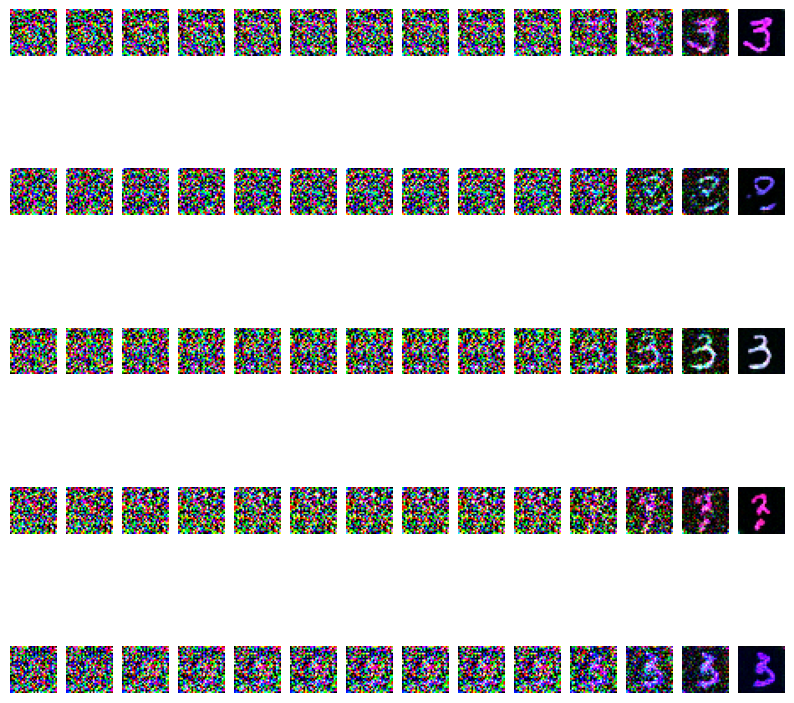

In [34]:
_ = plot_image_evolution_color(
    images=synthetic_images_t.cpu(),
    n_images=n_images,
    n_intermediate_steps=[0, 5, 200, 300, 400, 450, 470, 480, 490, 500, 1000,1500, 1800, 2000],
    figsize=(10, 10),
)